In [1]:
import pandas as pd
import duckdb as db

def sql(query, database = "../data/df_clean.csv"):
    con = db.connect(database)
    res = con.execute(query).df()
    con.close()
    return res


In [2]:
df_full = sql(""" SELECT * from df_clean LIMIT 20""")
df_full

,title,brand,price,rating,votes,sales_last_month,image_url,url,prime,category,rank,scraped_at
0,Garmin – Forerunner 55 - Montre GPS multi-acti...,Garmin,138.99,4.6,6532.0,1.0,https://m.media-amazon.com/images/I/61eTqEILa9...,https://www.amazon.fr/Garmin-Forerunner-multi-...,False,Objets connectés,1,2025-06-24 14:20:21.796320
1,Garmin Forerunner 255 - Montre GPS Multisports...,Garmin,203.99,4.5,1690.0,700.0,https://m.media-amazon.com/images/I/71tjy7Umf0...,https://www.amazon.fr/Garmin-GPS-Forerunner-25...,False,Objets connectés,2,2025-06-24 14:20:21.799403
2,"Garmin Forerunner 255, Music - Montre GPS Mult...",Garmin,244.00,4.5,616.0,700.0,https://m.media-amazon.com/images/I/51BxNNStky...,https://www.amazon.fr/Garmin-Forerunner-255-Mu...,False,Objets connectés,3,2025-06-24 14:20:21.802907
3,"Insta360 X5 - caméra d'action 360° 8K étanche,...",Insta360,589.99,4.5,559.0,300.0,https://m.media-amazon.com/images/I/71YjsbkkO9...,https://www.amazon.fr/Insta360-Invisible-rempl...,False,Objets connectés,4,2025-06-24 14:20:21.805683
4,Garmin Forerunner 255 – GPS-Laufuhr mit indivi...,Garmin,203.99,4.6,662.0,400.0,https://m.media-amazon.com/images/I/51oM3U58x2...,https://www.amazon.fr/Garmin-GPS-Forerunner-25...,False,Objets connectés,5,2025-06-24 14:20:21.808207
5,Garmin – Forerunner 55 - Montre GPS multi-acti...,Garmin,138.99,4.6,1389.0,300.0,https://m.media-amazon.com/images/I/51O-7CDSSM...,https://www.amazon.fr/Garmin-Forerunner-multi-...,False,Objets connectés,6,2025-06-24 14:20:21.810826
6,"Samsung R630 Galaxy Buds3 Pro, Silver",Samsung,173.49,4.1,571.0,300.0,https://m.media-amazon.com/images/I/71hvvK6bAT...,https://www.amazon.fr/Samsung-R630-Galaxy-Buds...,False,Objets connectés,7,2025-06-24 14:20:21.812748
7,"Garmin Forerunner 255, Music - Montre GPS Mult...",Garmin,243.99,4.5,165.0,200.0,https://m.media-amazon.com/images/I/51LVczCIWJ...,https://www.amazon.fr/Garmin-Forerunner-255-Mu...,False,Objets connectés,8,2025-06-24 14:20:21.814237
8,"Samsung Galaxy Buds FE Écouteurs sans Fil, Réd...",Samsung,65.64,4.3,483.0,200.0,https://m.media-amazon.com/images/I/51MaNu1aGh...,https://www.amazon.fr/%C3%89couteurs-R%C3%A9du...,False,Objets connectés,9,2025-06-24 14:20:21.817016
9,GoPro HERO13 Black - Caméra d'action étanche a...,GoPro,423.59,4.5,1088.0,100.0,https://m.media-amazon.com/images/I/615eTO83jL...,https://www.amazon.fr/GoPro-HERO13-Black-compa...,False,Objets connectés,10,2025-06-24 14:20:21.820954


In [ ]:
#Top produits avec le label "Prime"

sql("""SELECT title, price, rating, votes from df_clean WHERE prime = 'True' ORDER BY votes DESC """)

,title,price,rating,votes
0,TOZO T10 Ecouteur Bluetooth sans Fil avec Blue...,31.34,4.1,302739.0
1,TOZO A1 Mini écouteurs sans Fil Bluetooth 5.3 ...,24.99,4.2,92712.0
2,iJoy Casque sans Fil Bluetooth sur L'oreille a...,26.99,4.3,86467.0
3,Xleader [Smart Touch] Enceinte sans Fil SoundA...,27.99,4.4,10470.0
4,Xleader [ Smart Touch] Enceinte Bluetooth Soun...,26.99,4.4,10470.0
...,...,...,...,...
787,Traqueur GPS pour enfants - Clés de chien cach...,30.99,1.0,1.0
788,Traqueur GPS pour enfants - Clés de chien cach...,30.99,1.0,1.0
789,Traqueur GPS pour enfants - Clés de chien cach...,30.99,1.0,1.0
790,Traqueur GPS pour enfants - Clés de chien cach...,30.99,1.0,1.0


In [35]:
sql("""SELECT AVG(rating) from df_clean WHERE prime = 'True'""")
#sql("""SELECT AVG(rating) from df_clean""")


,avg(rating)
0,3.065025


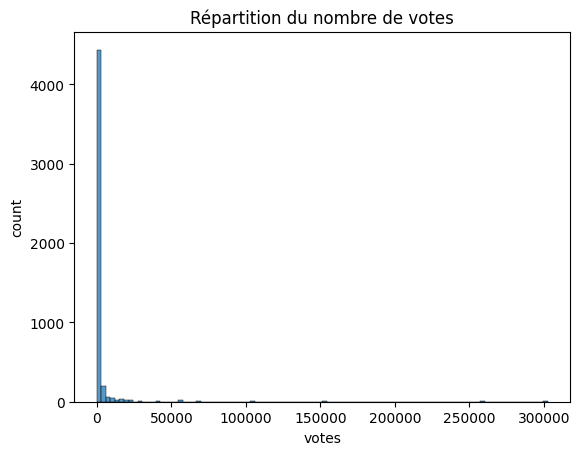

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns 

sns.histplot(df_full['votes'], bins=100, kde=False)
plt.xlabel("votes")
plt.ylabel("count")
plt.title("Répartition du nombre de votes")
plt.show()

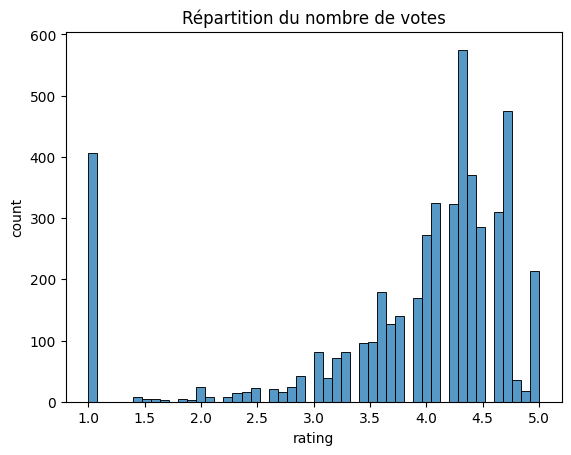

In [27]:
sns.histplot(df_full['rating'], bins=50, kde=False)
plt.xlabel("rating")
plt.ylabel("count")
plt.title("Répartition du nombre de votes")
plt.show()

In [35]:
import requests
import time
from bs4 import BeautifulSoup
from tqdm import tqdm
import pandas as pd

headers = {
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/18.1 Safari/605.1.15",
    "Accept-Language": "fr-FR,fr;q=0.9",
    "Accept-Encoding": "gzip, deflate, br"
}

prod = []

for u in tqdm(df_full['url']):
    try:
        r = requests.get(u, headers=headers, timeout=10)

        if r.status_code == 200:
            soup = BeautifulSoup(r.text, 'html.parser')

            # Catégorie
            card = soup.find('ul', class_='a-unordered-list a-horizontal a-size-small')
            cat = card.get_text(" > ", strip=True) if card else None

            # Titre
            title_tag = soup.find('span', class_="a-size-large product-title-word-break")
            title = title_tag.get_text(strip=True) if title_tag else None

            # Classement / Caractéristiques
            top_list = []
            top_card = soup.find('ul', class_="a-unordered-list a-nostyle a-vertical")
            if top_card:
                top_soup = top_card.find_all('span', class_="a-list-item")
                print(top_soup)
                top_list = [t.get_text(" ",strip=True) for t in top_soup]

            # Date de mise en ligne
            date_pub = None
            table_soup = soup.find('table', id='productDetails_detailBullets_sections1')
            if table_soup:
                rows = table_soup.find_all('tr')
                for row in rows:
                    th = row.find('th')
                    td = row.find('td')
                    if th and "date de mise en ligne" in th.get_text(strip=True).lower():
                        date_pub = td.get_text(strip=True) if td else None
                        break

            # Stockage
            prod.append({
                "titre": title,
                "url": u,
                "categorie": cat,
                "classement": top_list,
                "date_mise_en_ligne": date_pub
            })

        else:
            print("❌", r.status_code, u)

    except Exception as e:
        print(f"💥 Erreur pour {u} : {e}")

# Convertir en DataFrame
df_complément = pd.DataFrame(prod)



  5%|▌         | 1/20 [00:02<00:44,  2.33s/it]

[<span class="a-list-item"><span>48 en Sports et Loisirs (<a href="/gp/bestsellers/sports/ref=pd_zg_ts_sports">Voir les 100 premiers en Sports et Loisirs</a>)</span></span>, <span class="a-list-item"><span>1 en <a href="/gp/bestsellers/sports/489364031/ref=pd_zg_hrsr_sports">GPS de running</a></span></span>]


 10%|█         | 2/20 [00:04<00:43,  2.41s/it]

[<span class="a-list-item"><span>24 en Sports et Loisirs (<a href="/gp/bestsellers/sports/ref=pd_zg_ts_sports">Voir les 100 premiers en Sports et Loisirs</a>)</span></span>, <span class="a-list-item"><span>7 en <a href="/gp/bestsellers/sports/4371746031/ref=pd_zg_hrsr_sports">Trackers d'activité</a></span></span>]


 15%|█▌        | 3/20 [00:07<00:40,  2.41s/it]

[<span class="a-list-item"><span>24 en Sports et Loisirs (<a href="/gp/bestsellers/sports/ref=pd_zg_ts_sports">Voir les 100 premiers en Sports et Loisirs</a>)</span></span>, <span class="a-list-item"><span>2 en <a href="/gp/bestsellers/sports/489364031/ref=pd_zg_hrsr_sports">GPS de running</a></span></span>]


 20%|██        | 4/20 [00:09<00:37,  2.33s/it]

[<span class="a-list-item"><span>1 181 en High-Tech (<a href="/gp/bestsellers/electronics/ref=pd_zg_ts_electronics">Voir les 100 premiers en High-Tech</a>)</span></span>, <span class="a-list-item"><span>4 en <a href="/gp/bestsellers/electronics/4065994031/ref=pd_zg_hrsr_electronics">Caméras embarquées</a></span></span>]


 25%|██▌       | 5/20 [00:11<00:34,  2.29s/it]

[<span class="a-list-item"><span>24 en Sports et Loisirs (<a href="/gp/bestsellers/sports/ref=pd_zg_ts_sports">Voir les 100 premiers en Sports et Loisirs</a>)</span></span>, <span class="a-list-item"><span>2 en <a href="/gp/bestsellers/sports/489364031/ref=pd_zg_hrsr_sports">GPS de running</a></span></span>]


 30%|███       | 6/20 [00:13<00:31,  2.26s/it]

[<span class="a-list-item"><span>48 en Sports et Loisirs (<a href="/gp/bestsellers/sports/ref=pd_zg_ts_sports">Voir les 100 premiers en Sports et Loisirs</a>)</span></span>, <span class="a-list-item"><span>1 en <a href="/gp/bestsellers/sports/489364031/ref=pd_zg_hrsr_sports">GPS de running</a></span></span>]


 35%|███▌      | 7/20 [00:16<00:30,  2.32s/it]

[<span class="a-list-item"><span>1 927 en High-Tech (<a href="/gp/bestsellers/electronics/ref=pd_zg_ts_electronics">Voir les 100 premiers en High-Tech</a>)</span></span>, <span class="a-list-item"><span>38 en <a href="/gp/bestsellers/electronics/76028311031/ref=pd_zg_hrsr_electronics">Écouteurs à conduction osseuse</a></span></span>]


 40%|████      | 8/20 [00:18<00:27,  2.31s/it]

[<span class="a-list-item"><span>24 en Sports et Loisirs (<a href="/gp/bestsellers/sports/ref=pd_zg_ts_sports">Voir les 100 premiers en Sports et Loisirs</a>)</span></span>, <span class="a-list-item"><span>1 en <a href="/gp/bestsellers/sports/339998031/ref=pd_zg_hrsr_sports">Électronique sportive</a></span></span>, <span class="a-list-item"><span>2 en <a href="/gp/bestsellers/fashion/10143459031/ref=pd_zg_hrsr_fashion">Montres bracelet pour homme</a></span></span>]


 45%|████▌     | 9/20 [00:20<00:25,  2.29s/it]

[<span class="a-list-item"><span>1 721 en High-Tech (<a href="/gp/bestsellers/electronics/ref=pd_zg_ts_electronics">Voir les 100 premiers en High-Tech</a>)</span></span>, <span class="a-list-item"><span>56 en <a href="/gp/bestsellers/electronics/15513454031/ref=pd_zg_hrsr_electronics">Écouteurs intra-auriculaires</a></span></span>]


 50%|█████     | 10/20 [00:23<00:23,  2.32s/it]

[<span class="a-list-item"><span>3 511 en High-Tech (<a href="/gp/bestsellers/electronics/ref=pd_zg_ts_electronics">Voir les 100 premiers en High-Tech</a>)</span></span>, <span class="a-list-item"><span>16 en <a href="/gp/bestsellers/electronics/4065994031/ref=pd_zg_hrsr_electronics">Caméras embarquées</a></span></span>]


 55%|█████▌    | 11/20 [00:25<00:20,  2.30s/it]

[<span class="a-list-item"><span>371 en Hygiène et Santé (<a href="/gp/bestsellers/hpc/ref=pd_zg_ts_hpc">Voir les 100 premiers en Hygiène et Santé</a>)</span></span>, <span class="a-list-item"><span>5 en <a href="/gp/bestsellers/hpc/3160878031/ref=pd_zg_hrsr_hpc">Tensiomètres (Hygiène et Santé)</a></span></span>]


 60%|██████    | 12/20 [00:27<00:18,  2.29s/it]

[<span class="a-list-item"><span>1 325 en High-Tech (<a href="/gp/bestsellers/electronics/ref=pd_zg_ts_electronics">Voir les 100 premiers en High-Tech</a>)</span></span>, <span class="a-list-item"><span>8 en <a href="/gp/bestsellers/electronics/4065994031/ref=pd_zg_hrsr_electronics">Caméras embarquées</a></span></span>]


 65%|██████▌   | 13/20 [00:29<00:15,  2.23s/it]

[<span class="a-list-item"><span>191 en Animalerie (<a href="/gp/bestsellers/pet-supplies/ref=pd_zg_ts_pet-supplies">Voir les 100 premiers en Animalerie</a>)</span></span>, <span class="a-list-item"><span>1 en <a href="/gp/bestsellers/pet-supplies/27928760031/ref=pd_zg_hrsr_pet-supplies">Traqueurs pour animaux</a></span></span>]


 70%|███████   | 14/20 [00:32<00:14,  2.38s/it]

[<span class="a-list-item"><span>2 178 en High-Tech (<a href="/gp/bestsellers/electronics/ref=pd_zg_ts_electronics">Voir les 100 premiers en High-Tech</a>)</span></span>, <span class="a-list-item"><span>10 en <a href="/gp/bestsellers/electronics/4065994031/ref=pd_zg_hrsr_electronics">Caméras embarquées</a></span></span>]


 75%|███████▌  | 15/20 [00:34<00:11,  2.39s/it]

[<span class="a-list-item"><span>360 en High-Tech (<a href="/gp/bestsellers/electronics/ref=pd_zg_ts_electronics">Voir les 100 premiers en High-Tech</a>)</span></span>, <span class="a-list-item"><span>35 en <a href="/gp/bestsellers/electronics/14054961/ref=pd_zg_hrsr_electronics">Casques et écouteurs</a></span></span>]


 80%|████████  | 16/20 [00:37<00:09,  2.32s/it]

[<span class="a-list-item"><span>919 en High-Tech (<a href="/gp/bestsellers/electronics/ref=pd_zg_ts_electronics">Voir les 100 premiers en High-Tech</a>)</span></span>, <span class="a-list-item"><span>18 en <a href="/gp/bestsellers/electronics/16725697031/ref=pd_zg_hrsr_electronics">Enceintes Bluetooth portables</a></span></span>]


 85%|████████▌ | 17/20 [00:39<00:06,  2.32s/it]

[<span class="a-list-item"><span>48 en Sports et Loisirs (<a href="/gp/bestsellers/sports/ref=pd_zg_ts_sports">Voir les 100 premiers en Sports et Loisirs</a>)</span></span>, <span class="a-list-item"><span>1 en <a href="/gp/bestsellers/sports/489364031/ref=pd_zg_hrsr_sports">GPS de running</a></span></span>]


 90%|█████████ | 18/20 [00:41<00:04,  2.38s/it]

[<span class="a-list-item"><span>3 034 en High-Tech (<a href="/gp/bestsellers/electronics/ref=pd_zg_ts_electronics">Voir les 100 premiers en High-Tech</a>)</span></span>, <span class="a-list-item"><span>14 en <a href="/gp/bestsellers/electronics/4065994031/ref=pd_zg_hrsr_electronics">Caméras embarquées</a></span></span>]


 95%|█████████▌| 19/20 [00:44<00:02,  2.36s/it]

[<span class="a-list-item"><span>4 323 en High-Tech (<a href="/gp/bestsellers/electronics/ref=pd_zg_ts_electronics">Voir les 100 premiers en High-Tech</a>)</span></span>, <span class="a-list-item"><span>81 en <a href="/gp/bestsellers/electronics/16725697031/ref=pd_zg_hrsr_electronics">Enceintes Bluetooth portables</a></span></span>]


100%|██████████| 20/20 [00:46<00:00,  2.32s/it]

[<span class="a-list-item"><span>412 en High-Tech (<a href="/gp/bestsellers/electronics/ref=pd_zg_ts_electronics">Voir les 100 premiers en High-Tech</a>)</span></span>, <span class="a-list-item"><span>41 en <a href="/gp/bestsellers/electronics/14054961/ref=pd_zg_hrsr_electronics">Casques et écouteurs</a></span></span>]


In [36]:
df_complément

,titre,url,categorie,classement,date_mise_en_ligne
0,Garmin – Forerunner 55 - Montre GPS multi-acti...,https://www.amazon.fr/Garmin-Forerunner-multi-...,Sports et Loisirs > › > Électronique > › > GPS...,[48 en Sports et Loisirs ( Voir les 100 premie...,16 juin 2021
1,Garmin Forerunner 255 - Montre GPS Multisports...,https://www.amazon.fr/Garmin-GPS-Forerunner-25...,Sports et Loisirs > › > Électronique > › > Tra...,[24 en Sports et Loisirs ( Voir les 100 premie...,1 avril 2023
2,"Garmin Forerunner 255, Music - Montre GPS Mult...",https://www.amazon.fr/Garmin-Forerunner-255-Mu...,Sports et Loisirs > › > Électronique > › > GPS...,[24 en Sports et Loisirs ( Voir les 100 premie...,15 juin 2022
3,"Insta360 X5 - caméra d'action 360° 8K étanche,...",https://www.amazon.fr/Insta360-Invisible-rempl...,High-Tech > › > Photo et caméscopes > › > Camé...,[1 181 en High-Tech ( Voir les 100 premiers en...,22 avril 2025
4,Garmin Forerunner 255 – GPS-Laufuhr mit indivi...,https://www.amazon.fr/Garmin-GPS-Forerunner-25...,Sports et Loisirs > › > Électronique > › > GPS...,[24 en Sports et Loisirs ( Voir les 100 premie...,1 avril 2023
5,Garmin – Forerunner 55 - Montre GPS multi-acti...,https://www.amazon.fr/Garmin-Forerunner-multi-...,Sports et Loisirs > › > Électronique > › > GPS...,[48 en Sports et Loisirs ( Voir les 100 premie...,16 juin 2021
6,"Samsung R630 Galaxy Buds3 Pro, Silver",https://www.amazon.fr/Samsung-R630-Galaxy-Buds...,"High-Tech > › > Casques, écouteurs et accessoi...",[1 927 en High-Tech ( Voir les 100 premiers en...,10 juillet 2024
7,"Garmin Forerunner 255, Music - Montre GPS Mult...",https://www.amazon.fr/Garmin-Forerunner-255-Mu...,Mode > › > Homme > › > Montres > › > Montres b...,[24 en Sports et Loisirs ( Voir les 100 premie...,14 juin 2022
8,"Samsung Galaxy Buds FE Écouteurs sans Fil, Réd...",https://www.amazon.fr/%C3%89couteurs-R%C3%A9du...,"High-Tech > › > Casques, écouteurs et accessoi...",[1 721 en High-Tech ( Voir les 100 premiers en...,4 octobre 2023
9,GoPro HERO13 Black - Caméra d'action étanche a...,https://www.amazon.fr/GoPro-HERO13-Black-compa...,High-Tech > › > Photo et caméscopes > › > Camé...,[3 511 en High-Tech ( Voir les 100 premiers en...,4 septembre 2024


In [37]:
import re

df_complément['categorie'] = df_complément['categorie'].astype(str).str.replace(">", "", regex=False).str.replace("›", ".",regex=False).str.replace(" ","").str.split(".")
#df_complément['caracteristiques'] = df_complément['caracteristiques'].astype(str).apply(lambda x : re.search("(\d+)\s+en\s+([a-zA-Z\s]+)", x))
df_complément

,titre,url,categorie,classement,date_mise_en_ligne
0,Garmin – Forerunner 55 - Montre GPS multi-acti...,https://www.amazon.fr/Garmin-Forerunner-multi-...,"[SportsetLoisirs, Électronique, GPS, GPSderunn...",[48 en Sports et Loisirs ( Voir les 100 premie...,16 juin 2021
1,Garmin Forerunner 255 - Montre GPS Multisports...,https://www.amazon.fr/Garmin-GPS-Forerunner-25...,"[SportsetLoisirs, Électronique, Trackersd'acti...",[24 en Sports et Loisirs ( Voir les 100 premie...,1 avril 2023
2,"Garmin Forerunner 255, Music - Montre GPS Mult...",https://www.amazon.fr/Garmin-Forerunner-255-Mu...,"[SportsetLoisirs, Électronique, GPS, GPSderunn...",[24 en Sports et Loisirs ( Voir les 100 premie...,15 juin 2022
3,"Insta360 X5 - caméra d'action 360° 8K étanche,...",https://www.amazon.fr/Insta360-Invisible-rempl...,"[High-Tech, Photoetcaméscopes, Camérasembarquées]",[1 181 en High-Tech ( Voir les 100 premiers en...,22 avril 2025
4,Garmin Forerunner 255 – GPS-Laufuhr mit indivi...,https://www.amazon.fr/Garmin-GPS-Forerunner-25...,"[SportsetLoisirs, Électronique, GPS, GPSderunn...",[24 en Sports et Loisirs ( Voir les 100 premie...,1 avril 2023
5,Garmin – Forerunner 55 - Montre GPS multi-acti...,https://www.amazon.fr/Garmin-Forerunner-multi-...,"[SportsetLoisirs, Électronique, GPS, GPSderunn...",[48 en Sports et Loisirs ( Voir les 100 premie...,16 juin 2021
6,"Samsung R630 Galaxy Buds3 Pro, Silver",https://www.amazon.fr/Samsung-R630-Galaxy-Buds...,"[High-Tech, Casques,écouteursetaccessoires, Ca...",[1 927 en High-Tech ( Voir les 100 premiers en...,10 juillet 2024
7,"Garmin Forerunner 255, Music - Montre GPS Mult...",https://www.amazon.fr/Garmin-Forerunner-255-Mu...,"[Mode, Homme, Montres, Montresbracelet]",[24 en Sports et Loisirs ( Voir les 100 premie...,14 juin 2022
8,"Samsung Galaxy Buds FE Écouteurs sans Fil, Réd...",https://www.amazon.fr/%C3%89couteurs-R%C3%A9du...,"[High-Tech, Casques,écouteursetaccessoires, Ca...",[1 721 en High-Tech ( Voir les 100 premiers en...,4 octobre 2023
9,GoPro HERO13 Black - Caméra d'action étanche a...,https://www.amazon.fr/GoPro-HERO13-Black-compa...,"[High-Tech, Photoetcaméscopes, Camérasembarquées]",[3 511 en High-Tech ( Voir les 100 premiers en...,4 septembre 2024


In [52]:
def clean_class(liste_class) :
    class_clean = []
    for l in liste_class : 
        class_clean.append(re.findall(r"(\d+)\s+en\s+([a-zA-Z\s]+)", l))
    return class_clean

clean_class(df_complément['classement'][0])

[[('48', 'Sports et Loisirs ')], [('1', 'GPS de running')]]

In [39]:
df_complément['classement'][2]

['24 en Sports et Loisirs ( Voir les 100 premiers en Sports et Loisirs )',
 '2 en GPS de running']